# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary in this study.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
import seaborn as sns

from collections import OrderedDict
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, bds
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## Define Functions
    Defines helper functions

In [2]:
# Define Mean Absolute Percentage Error
def printMAEpred(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    ape = 100*(abs((y_pred - y_true.T) / y_true.T));
    for i in horizonSteps:
        print('Prediction for ' + str(i) + ' step: MAE = ' + str(round(np.mean(ae[0,:i]), 2)) + ' (' + str(round(np.mean(ape[0,:i]), 2)) + '%)'  )

In [3]:
# Compute MAE over an array of different horizons
def horizonMAE(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[:i]), 2))
    return list_MAE;

In [4]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true) / y_true));

In [5]:
# Compute MAPE over an array of different horizons
def horizonMAPE(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[:i]), 2))
        return list_MAPE;

In [6]:
# Evaluate combinations of p, d and q values for an ARIMA model
def ARIMA_grid(dataset, arimaCfg, isLog):
    df_IC = pd.DataFrame( columns=['ARIMA(p, d, q)', 'AIC', 'BIC', 'HQIC'])
    df_IC = df_IC.set_index('ARIMA(p, d, q)')
    dict_arimaFit  = {} 
    dict_arimaPred = {} 
    modelNum = 0;
    totalModelNum = len(arimaCfg.p_range)*len(arimaCfg.d_range)*len(arimaCfg.q_range)
    for p in arimaCfg.p_range:
        for d in arimaCfg.d_range:
            for q in arimaCfg.q_range:
                order = (p,d,q)
                modelNum+=1;
                print("%d/%d " % (modelNum, totalModelNum))
                try:
                    model = ARIMA(dataset, order=order);
                    model_fit = model.fit(disp=0);

                    model_str = 'ARIMA' + str(order)
                    df_IC = df_IC.append(pd.DataFrame({'AIC':model_fit.aic, 'BIC':model_fit.bic, \
                                                       'HQIC':model_fit.hqic}, index =[model_str]), ignore_index=False)
                    
                    if (isLog):
                        dict_arimaFit[model_str]  = np.e**(model_fit.predict(typ='levels'));
                        dict_arimaPred[model_str] = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                    else:
                        dict_arimaFit[model_str]  = model_fit.predict(typ='levels');
                        dict_arimaPred[model_str] = model_fit.forecast(steps=stepsToForecast[-1])[0];
                except:
                    continue
    return dict_arimaFit, dict_arimaPred, df_IC

In [7]:
def ARIMA_train_val_forwardChaining(sequence, minSamplesTrain, n_steps_forecast, n_steps_jump):
    end_ix=0;
    X, Xcv = list(), list()
    i=0; # Index of individual training set at each train/val split
        
    # Iterate through all train/val splits
    while 1:
        end_ix = minSamplesTrain+n_steps_jump*i;
        # TRAINING DATA
        seq_x = sequence[0:end_ix] 
        X.append(seq_x)
        # TRAINING DATA
        seq_xcv = sequence[end_ix:end_ix+n_steps_forecast]
        Xcv.append(seq_xcv)

        i+=1;
          
        # Once val data crosses time series length return   
        if ((minSamplesTrain+n_steps_jump*i+n_steps_forecast) > len(sequence)):
            break
            
    return X, Xcv

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [8]:
# df = Dataframe with an index and a value column
# title = Title of data being used
# xlab = Label of df.index
# ylab = Label of df.values
# seasonal_periods = The repetition cycle

previousStepsToShow = 15;

#stepsToForecast = [1, 3, 12]
#df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
#df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
#df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
#title = 'CPIAUC'
#xlab = 'Months/Year'; 
#ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';
#seasonal_periods = 12

#stepsToForecast = [1, 5, 21]
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Working Days/Year'; 
#ylab = 'Closing Price (Euro)';
#seasonal_periods = 5

stepsToForecast = [1, 5, 21]
df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
title = 'SP500'
xlab = 'Days/Year'; 
ylab = 'Closing Price ($)';
seasonal_periods=5;

# Stationarity of the Time-Series

## Data transformation and its graphical representation
    This section allows to understand the representation of the series after its transformation to achieve stationarity

    Box-Cox transformations such as the logarithmic one can help to stabilise the variance of a time series. 
    Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.
    Note: The order Box-Cox transformation, and then, differencing, is important!

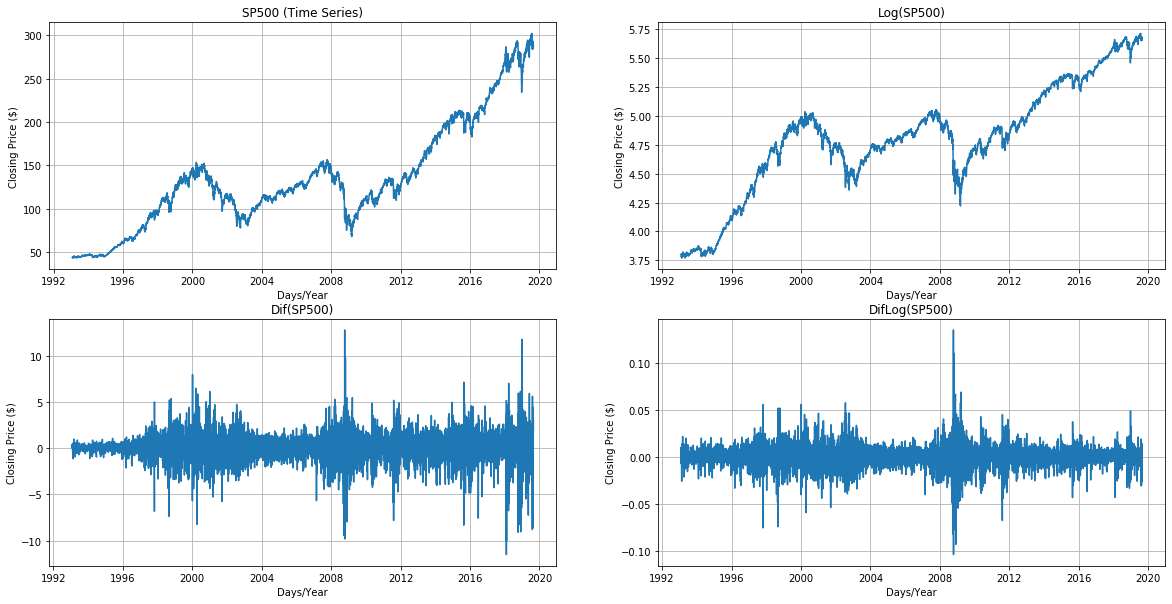

In [9]:
fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
plt.title(title + ' (Time Series)')
plt.plot(df_train)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(222)
plt.title('Log(' + title + ')')
plt.plot(np.log(df_train))
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(223)
plt.title('Dif(' + title + ')')
plt.plot(df_train.diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

fig.add_subplot(224)
plt.title('DifLog(' + title + ')')
plt.plot(np.log(df_train).diff().dropna())
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.grid()

plt.show()

## Normality tests

### Jarque-Bera 
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [10]:
jb, jbpval = stats.jarque_bera(df_train)
print("Jarque-Bera Test for " + title)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train))
print("Jarque-Bera Test for Log(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(df_train.diff().dropna())
print("Jarque-Bera Test for Diff(" + title + ")")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print("")
jb, jbpval = stats.jarque_bera(np.log(df_train).diff().dropna())
print("Jarque-Bera Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval) 

Jarque-Bera Test for SP500
Statistic: 726.0377
p-value: 0.0000

Jarque-Bera Test for Log(SP500)
Statistic: 135.9271
p-value: 0.0000

Jarque-Bera Test for Diff(SP500)
Statistic: 12828.4972
p-value: 0.0000

Jarque-Bera Test for Diff(Log(SP500))
Statistic: 29088.8787
p-value: 0.0000


### Kolmogorov-Smirnov
    ?

In [11]:
ks, kspval = stats.kstest(df_train.values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)  
print("")
ks, kspval = stats.kstest(np.log(df_train), 'norm')
print("Kolmogorov-Smirnov Test for Log(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(df_train.diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(" + title + ")")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval)
print("")
ks, kspval = stats.kstest(np.log(df_train).diff().dropna(), 'norm')
print("Kolmogorov-Smirnov Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kolmogorov-Smirnov Test
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Log(SP500)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(SP500)
Statistic: 1.0000
p-value: 0.0000

Kolmogorov-Smirnov Test for Diff(Log(SP500))
Statistic: 0.5539
p-value: 0.0000


## Unit Root and Stationarity Tests

### The Augmented Dickey-Fuller test 
    ?
    # Used to test for a unit root in a univariate process in the presence of serial correlation.

In [12]:
result = adfuller(df_train['train'].values, regression='c')
print("Augmented Dickey Fuller Test for " + title)
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train'].values), regression='c')
print("Augmented Dickey Fuller Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))
print("")
result = adfuller(df_train['train'].diff().dropna(), regression='c')
print("Augmented Dickey Fuller Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print ("\t%s: %.3f" % (key, value))
print("")
result = adfuller(np.log(df_train['train']).diff().dropna().values, regression='c')
print("Augmented Dickey Fuller Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey Fuller Test for SP500
Statistic: 0.3972
p-value: 0.9814
Used lags: 17
Num obs: 6676
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Log(SP500)
Statistic: -1.1596
p-value: 0.6907
Used lags: 34
Num obs: 6659
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(SP500)
Statistic: -20.1409
p-value: 0.0000
Used lags: 16
Num obs: 6676
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Augmented Dickey Fuller Test for Diff(Log(SP500))
Statistic: -14.7617
p-value: 0.0000
Used lags: 33
Num obs: 6659
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Kwiatkowski-Phillips-Schmidt-Shin
    ?
    # Test for level or trend stationarity

In [13]:
result = kpss(df_train['train'].values, regression='c')
print("KPSS Test for " + title)
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train'].values), regression='c')
print("KPSS Test for Log(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(df_train['train'].diff().dropna(), regression='c')
print("KPSS Test for Diff(" + title + ")")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));
print("")
result = kpss(np.log(df_train['train']).diff().dropna().values, regression='c')
print("KPSS Test for Diff(Log(" + title + "))")
print("Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value));

KPSS Test for SP500
Statistic: 13.2820
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Log(SP500)
Statistic: 13.2698
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(SP500)
Statistic: 0.2234
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347

KPSS Test for Diff(Log(SP500))
Statistic: 0.1275
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


## Correlation plots
    These plots are useful for identifying non-stationary time series 

    This also gives an idea of the order of the model by:
        AR(p) - p from the partial autocorrelation plot
        I(d)  - d from the number of Diffs your dataset is using
        MA(q) - q from the autocorrelation plot

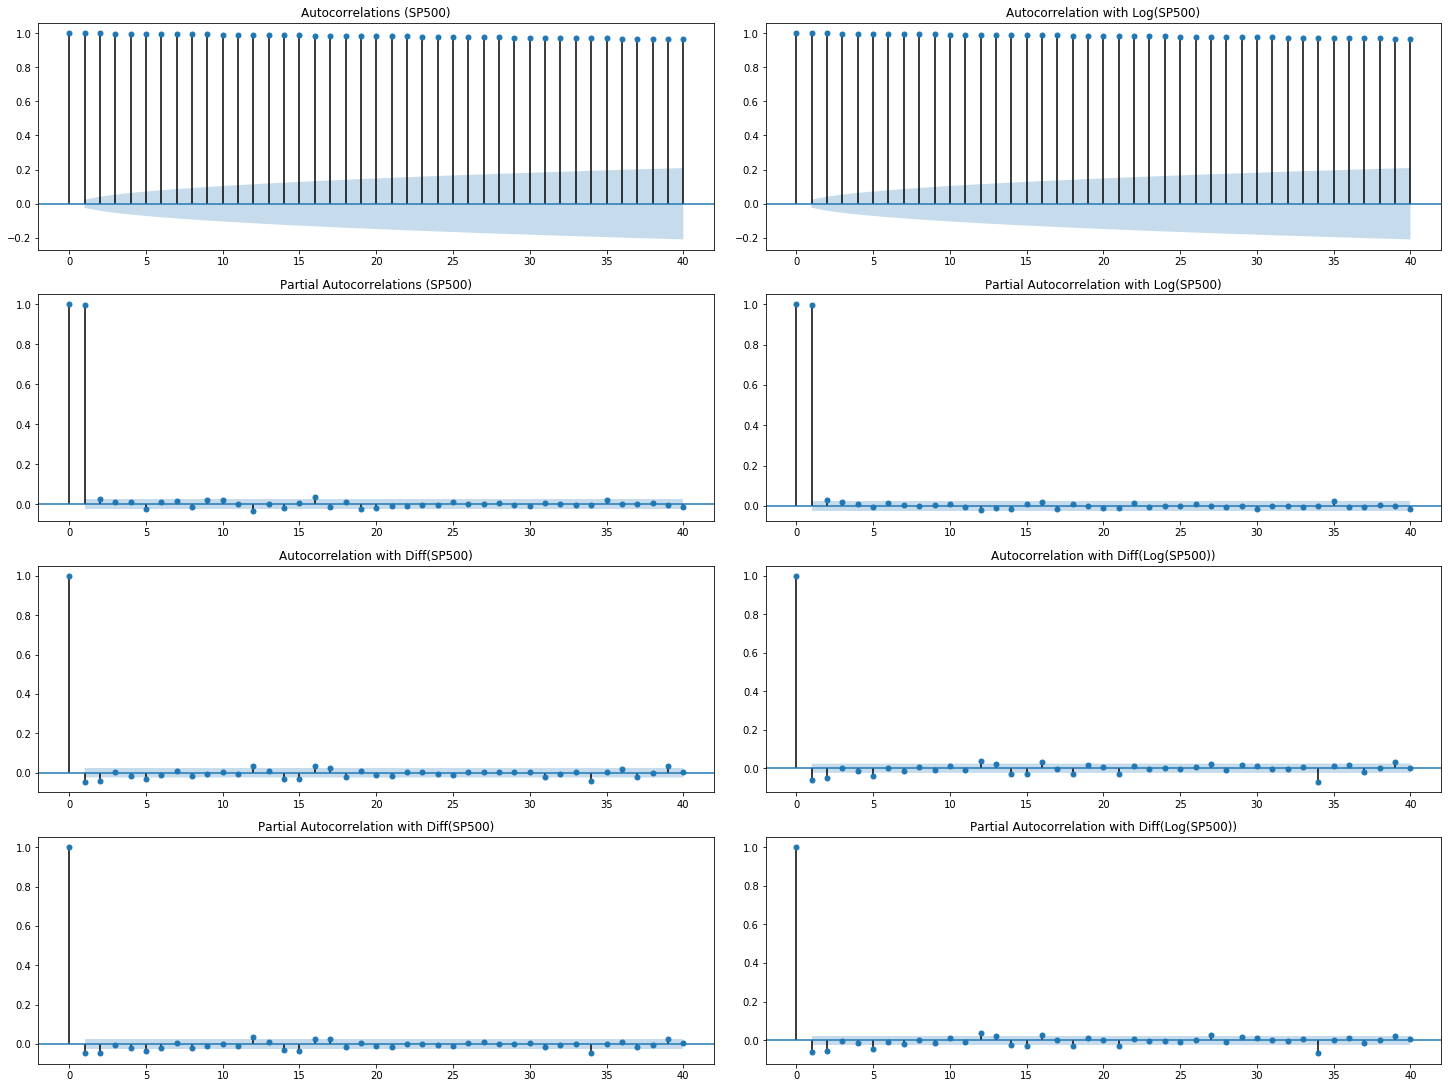

In [14]:
maxLags = 40

fig = plt.figure(figsize=(20,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df_train, lags=maxLags, ax=ax_acf, title='Autocorrelations (' + title + ')')
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df_train, lags=maxLags, ax=ax_pacf, title='Partial Autocorrelations (' + title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfLog = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(np.log(df_train), lags=maxLags, ax=ax_acfLog, title='Autocorrelation with Log('+ title + ')')
# Partial auto-correlation function for time series transformed with Log
ax_pacfLog = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train), lags=maxLags, ax=ax_pacfLog, title='Partial Autocorrelation with Log('+ title + ')');

# Auto-correlation function for time series transformed with Diff
ax_acfDiff = fig.add_subplot(spec[2, 0])
sm.graphics.tsa.plot_acf(df_train.diff().dropna(), lags=maxLags, ax=ax_acfDiff, title='Autocorrelation with Diff('+ title + ')')
# Partial auto-correlation function for time series transformed with Diff
ax_pacfDiff = fig.add_subplot(spec[3, 0])
sm.graphics.tsa.plot_pacf(df_train.diff().dropna(), lags=maxLags, ax=ax_pacfDiff, title='Partial Autocorrelation with Diff('+ title + ')');

# Auto-correlation function for time series transformed with Log
ax_acfDiffLog = fig.add_subplot(spec[2, 1])
sm.graphics.tsa.plot_acf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_acfDiffLog, title='Autocorrelation with Diff(Log('+ title + '))')
# Partial auto-correlation function for time series transformed with Log
ax_pacfDiffLog = fig.add_subplot(spec[3, 1])
sm.graphics.tsa.plot_pacf(np.log(df_train).diff().dropna(), lags=maxLags, ax=ax_pacfDiffLog, title='Partial Autocorrelation with Diff(Log('+ title + '))');

plt.show()

# Pre-processing
    From now on, we must choose whether we go with the Log(Time-Series) or not
    This should be done to remove stationarity of the data, so that ARIMA can work
    In addition, if the model is multiplicative we need to use log to make it additive as ARIMA relies on that assumption
    The previously seen differentiated data enters in the I component of the ARIMA model it will take care of differenciating for us

In [15]:
isLog = True

if (isLog):
    df_Train = pd.DataFrame(np.log(df_train), index = df_train.index).copy()
else:
    df_Train = df_train.copy()

# ARIMA Selection

## Model training
    ?

In [16]:
# Range of ARIMA models to compute
class arimaCfg:
    p_range = range(4, 5) # [1,7)
    d_range = range(1, 3) # [1,3)
    q_range = range(3, 6) # [1,7)

dict_arimaFit, dict_arimaPred, df_IC = ARIMA_grid(df_Train.values, arimaCfg, isLog)
#dict_arimaFit, dict_arimaPred, df_IC

1/6 
2/6 
3/6 
4/6 
5/6 
6/6 


## Model Comparison based on Information Criteria
    AIC -
    BIC - 
    HQIC -

In [17]:
print(df_IC[['AIC']].sort_values('AIC').head().rename(columns={'AIC': 'TOP 5 AIC'}))
print(" ")
print(df_IC[['BIC']].sort_values('BIC').head().rename(columns={'BIC': 'TOP 5 BIC'}))
print(" ")
print(df_IC[['HQIC']].sort_values('HQIC').head().rename(columns={'HQIC': 'TOP 5 HQIC'}))

                   TOP 5 AIC
ARIMA(4, 1, 3) -40850.258442
ARIMA(4, 1, 4) -40848.954401
ARIMA(4, 2, 4) -40782.127143
ARIMA(4, 2, 3) -40780.961164
ARIMA(4, 2, 5) -40776.678978
 
                   TOP 5 BIC
ARIMA(4, 1, 3) -40788.979085
ARIMA(4, 1, 4) -40780.866226
ARIMA(4, 2, 3) -40719.683152
ARIMA(4, 2, 4) -40714.040463
ARIMA(4, 2, 5) -40701.783630
 
                  TOP 5 HQIC
ARIMA(4, 1, 3) -40829.094884
ARIMA(4, 1, 4) -40825.439336
ARIMA(4, 2, 3) -40759.797912
ARIMA(4, 2, 4) -40758.612418
ARIMA(4, 2, 5) -40750.812781


## Selected Models Information Criteria Comparison
    Evaluate models based on their Information Criteria

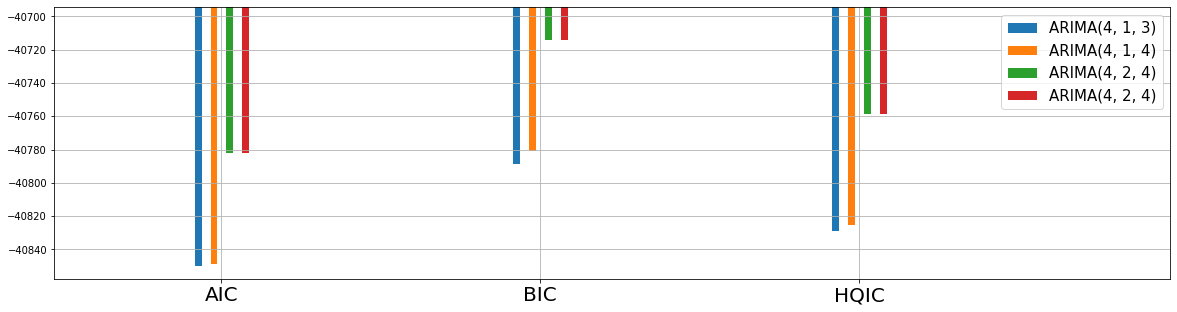

In [18]:
labels = ['ARIMA(4, 1, 3)',
          'ARIMA(4, 1, 4)',
          'ARIMA(4, 2, 4)',
          'ARIMA(4, 2, 4)']

plt.figure(figsize=(20,5))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

# set width of bar
spacing = 0.05
barWidth = 0.025
r = np.arange(3) - ((len(labels)/2)-1)*spacing

for i in np.arange(len(labels)):
    plt.bar(r, df_IC.loc[labels[i]].values, width=barWidth, edgecolor='white', label=labels[i])
    r = [x + spacing for x in r]
 
plt.xticks([r + barWidth for r in range(3)], ['AIC', 'BIC', 'HQIC'], fontsize='20')
plt.axis((-0.5, 3.0, min(df_IC.min())-0.05*(max(df_IC.max())-min(df_IC.min())), max(df_IC.max())+0.05*(max(df_IC.max())-min(df_IC.min()))))
plt.legend(loc='best')
plt.grid()
plt.show()

## Selected Models Cross-Validation
    ?

In [44]:
X, Xcv = ARIMA_train_val_forwardChaining(df_Train.values[-240:], 200, stepsToForecast[-1], 1)

len(X)
# PUTA DA CROSS VALIDATION
# - BOX PLOT COM ERROS DE FORECAST (baseado em forward chaining)

20

In [86]:
for arimaModel in labels[0:1]:
    print(arimaModel[5:])
    print(arimaModel)

(4, 1, 3)
ARIMA(4, 1, 3)


In [87]:
labels

['ARIMA(4, 1, 3)', 'ARIMA(4, 1, 4)', 'ARIMA(4, 2, 4)', 'ARIMA(4, 2, 4)']

In [21]:
import ast

def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return

In [146]:
labels = ['ARIMA(4, 2, 3)',
          'ARIMA(4, 1, 3)',
          'ARIMA(4, 2, 4)']
dict_MAE = {} 

for model_str in labels:
    list_conv = list()
    list_mae = list()
    list_mape = list()
    print("%s" % model_str);
    for i in np.arange(len(X)):
        try:
            model = ARIMA(X[i], order=parse_tuple(model_str[5:]));
            model_fit = model.fit(disp=0);

            if (~np.isnan(model_fit.mle_retvals.get('fopt'))):
                if (isLog):
                    predictions_array = np.e**(model_fit.forecast(steps=stepsToForecast[-1])[0]);
                else:
                    predictions_array = model_fit.forecast(steps=stepsToForecast[-1])[0];

                list_conv.append(i)

                mae = horizonMAE(Xcv[i], predictions_array, stepsToForecast)
                list_mae.append(mae)

                mape = horizonMAPE(Xcv[i], predictions_array, stepsToForecast)
                list_mape.append(mape)

                print("%d/%d - Success" % (i+1, len(X)));
            else:
                print("%d/%d - No" % (i+1, len(X)));
        except:
            print("%d/%d - No" % (i+1, len(X)));
            continue

    dict_MAE[model_str] =  {'conv': list_conv, 'mae': list_mae, 'mape': list_mape}  

1/20 - Success
2/20 - Success
3/20 - No
4/20 - Success
5/20 - Success
6/20 - No
7/20 - Success
8/20 - Success
9/20 - Success
10/20 - No
11/20 - No
12/20 - Success
13/20 - No
14/20 - No
15/20 - Success
16/20 - Success
17/20 - Success
18/20 - Success
19/20 - Success
20/20 - Success
1/20 - No
2/20 - No
3/20 - Success
4/20 - Success
5/20 - Success
6/20 - Success
7/20 - Success
8/20 - No
9/20 - Success
10/20 - Success
11/20 - Success
12/20 - Success
13/20 - Success
14/20 - Success
15/20 - Success
16/20 - Success
17/20 - No
18/20 - Success
19/20 - Success
20/20 - Success
1/20 - No
2/20 - No
3/20 - No
4/20 - No
5/20 - No
6/20 - No
7/20 - No
8/20 - No
9/20 - No
10/20 - No
11/20 - No
12/20 - No
13/20 - No
14/20 - No
15/20 - No
16/20 - No
17/20 - No
18/20 - No
19/20 - No
20/20 - No


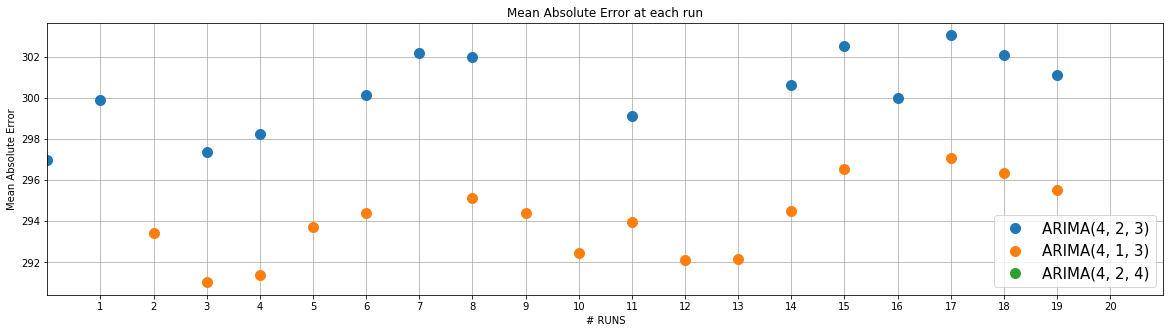

In [147]:
# Plot Mean Absolute Errors of each run
PRED_IX = 3 # longer horizon

plt.figure(figsize=(20,5))
for model_str in labels:
    plt.plot(dict_MAE[model_str]['conv'], [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']], 'o', markersize=10)
#plt.legend([model_str for model_str in labels if len(dict_MAE[model_str]['conv'])>0])
plt.legend(labels)
plt.xlabel('# RUNS')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at each run')
if (len(X) > 500):
    plt.xticks(np.arange(0, len(X), 100))
if (len(X) > 250):
    plt.xticks(np.arange(0, len(X), 50))
elif (len(X) > 50):
    plt.xticks(np.arange(0, len(X), 10))
else:
    plt.xticks(np.arange(1,len(X)+1))
plt.xlim([0, len(X)+1])
plt.grid()
plt.show()

In [158]:
x_bp = np.repeat('Cross-validation', len(y_bp))
x_bp

array(['Cross-validation', 'Cross-validation', 'Cross-validation',
       'Cross-validation', 'Cross-validation', 'Cross-validation',
       'Cross-validation', 'Cross-validation', 'Cross-validation',
       'Cross-validation', 'Cross-validation', 'Cross-validation',
       'Cross-validation', 'Cross-validation'], dtype='<U16')

<Figure size 1440x360 with 0 Axes>

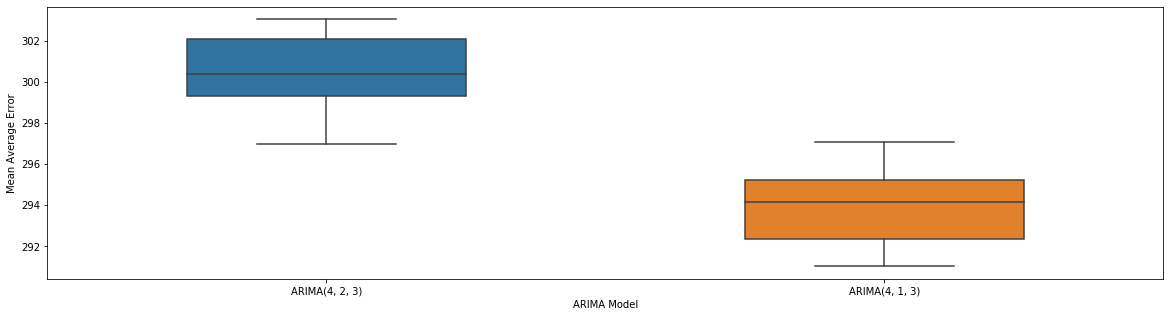

In [208]:
plt.figure(figsize=(20, 5))
y_bp = []
x_bp = np.empty((0))
for model_str in labels:
    if (len(dict_MAE[model_str]['conv'])>0):
        mae = [mae[PRED_IX-1] for mae in dict_MAE[model_str]['mae']]
        y_bp.extend(mae)
        x_bp = np.append(x_bp, np.repeat(model_str, len(mae)))
        df_bp = pd.DataFrame(data={'ARIMA Model': x_bp, 'Mean Average Error': y_bp})
bplot=sns.boxplot(y='Mean Average Error', x='ARIMA Model', data=df_bp, width=0.5) 
plt.show()

In [48]:

# Plot Mean Absolute Errors of each run
x_bp = np.concatenate(np.repeat('Cross-validation', len(list_cv_mae)), axis = 0)
y_bp = np.concatenate(list_train_mae, list_cv_mae), axis = 0)

df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.2)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.2)
plt.xlim([-1, 1.5])
plt.text(-0.70, 1*trainMae, 'Average: ' + str(round(trainMae,4)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, 1*cvMae, 'Average: ' + str(round(cvMae,4)), fontsize=14, color='r', fontweight='bold')

plt.show()

ValueError: setting an array element with a sequence.

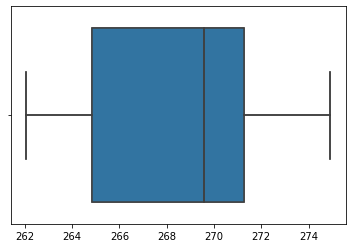

In [36]:

sns.boxplot(dict_MAE[labels[0]]['mae'])
plt.show()

In [31]:
# Plot Mean Absolute Errors of each run
x_bp = np.concatenate(( np.repeat('Cross-validation', len(dict_MAE[labels[0]]['mae'])))) #np.repeat('Train', len(list_train_mae))
                      
y_bp = np.concatenate((dict_MAE[labels[0]]['mae']), axis = 0)

df_bp = pd.DataFrame(data={'Data Type': x_bp, 'Mean Average Error': y_bp})

plt.figure(figsize=(20, 5))
bplot=sns.boxplot(y='Mean Average Error', x='Data Type', data=df_bp, width=0.5)
bplot.artists[0].set_facecolor('blue')
bplot.artists[1].set_facecolor('red')
plt.title('Boxplot with average Training, Cross-Validation and Testing error');
plt.plot([-1,0], [trainMae, trainMae],'b--', lw=2, alpha=0.2)
plt.plot([-1,1], [cvMae, cvMae],'r--', lw=2, alpha=0.2)
plt.xlim([-1, 1.5])
plt.text(-0.70, 1*trainMae, 'Average: ' + str(round(trainMae,4)), fontsize=14, color='b', fontweight='bold')
plt.text(0.30, 1*cvMae, 'Average: ' + str(round(cvMae,4)), fontsize=14, color='r', fontweight='bold')

plt.show()

ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
dict_arimaPred, df_IC = ARIMA_grid(df_Train.values)

# Model Validation

In [ ]:
# Pick you favourite's models order
order = (4, 1, 3)
model = ARIMA(df_Train.values, order=order)
model_fit = model.fit(disp=0);
df_res = pd.DataFrame({"resid": model_fit.resid}, index= df_Train.index[order[1]:])
model_fit.summary()

In [ ]:
plt.figure(figsize=(20,7))
labels = ['Training and testing data', 'Fitted values', 'Predicted values']
plt.title(title + " prediction with ARIMA" + str(order))
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 3 )
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit['ARIMA' + str(order)][-previousStepsToShow:], 'b--' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred['ARIMA' + str(order)], 'r--*' , linewidth = 2)
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3 )
plt.legend(labels, loc='upper left')
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab)
plt.show()

In [ ]:
# Plot model residuals
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title('ARIMA' + str(order) +' Residuals')
plt.grid()

In [ ]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.title('ARIMA' + str(order) + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, normed=1, edgecolor='black')

df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_res), 6)))
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_res), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

In [ ]:
print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

### Normality Test

In [ ]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)
print(" ")

s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 
print(" ")

jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)
print(" ")

ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

### Engle\'s Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [ ]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

### Test for No Autocorrelation

#### Brock–Dechert–Scheinkman test

In [ ]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

#### Breusch-Godfrey test

In [ ]:
lm, lmpval, fval, fpval = acorr_breusch_godfrey(model_fit, nlags = max(order[0], order[2]))
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')

print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

#### Box-Pierce test

In [ ]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)
df_boxpierce = pd.DataFrame({'lags':range(1, maxLags), 'bp statistic': bpvalue, 'p-value':bppvalue})
print(df_boxpierce[['lags', 'bp statistic', 'p-value']].to_string(index = False))

#### Ljung-Box test

In [ ]:
df_ljungbox = pd.DataFrame({'lags':range(1, maxLags), 'lb statistic': bpvalue, 'p-value':pvalue})
print(df_ljungbox[['lags', 'lb statistic', 'p-value']].to_string(index = False))

In [ ]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()

In [ ]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

# Forecast Performance Overview 

In [ ]:
labels = ['Real Closing price', 
          'ARIMA(4, 1, 3)',
          'ARIMA(4, 1, 4)',
          'ARIMA(4, 2, 4)']

plt.figure(figsize=(20,7))
plt.title(title + ' fitting and forecasting')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o', linewidth = 3, label='Real values')
for i in np.arange(len(labels)-1):
    arimaPlot = plt.plot(1+np.arange(stepsToForecast[-1]), dict_arimaPred[labels[i+1]], '--*' , linewidth = 3, label = labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, dict_arimaFit[labels[i+1]][-previousStepsToShow:], '--' , linewidth = 2, color=arimaPlot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 ) # label = labels[i+1]  legenda
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow,+stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future working days')
plt.ylabel(ylab);
plt.show()

for i in np.arange(len(labels)-1):
    print(labels[i+1])
    printMAEpred(df_test.values, dict_arimaPred[labels[i+1]], stepsToForecast)
    print(" ")